In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
!pip install tensorflow

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
train_dir = '/kaggle/input/plant-village/train'
test_dir = '/kaggle/input/plant-village/test'
val_dir = '/kaggle/input/plant-village/val'

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

In [7]:
img_size = 224
batch_size = 32

In [8]:
# Directory with all classes inside (flat structure)
data_dir = r'C:\UTeM Exercises\SEM 4\Neural Network\PlantVillage'

In [9]:
#Augment images to reach 500 in Potato_healthy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
import numpy as np

# Set path to Potato_healthy folder
source_dir = r"C:\UTeM Exercises\SEM 4\Neural Network\PlantVillage\Potato___healthy"
target_dir = source_dir  

augmentor = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load existing image names
images = os.listdir(source_dir)
current_count = len(images)
i = 0
target_count = 500  

while i + current_count < target_count:
    img = load_img(os.path.join(source_dir, images[i % current_count]))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    for batch in augmentor.flow(x, batch_size=1, save_to_dir=target_dir, save_prefix='aug', save_format='jpeg'):
        i += 1
        if i + current_count >= target_count:
            break

print(f"Potato_healthy is now augmented to {target_count} images.")


Potato_healthy is now augmented to 500 images.


In [10]:
# Data generator with preprocessing and 20% validation split
datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    validation_split=0.2  # 80% train, 20% validation
)

In [11]:
# Training generator
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 3600 images belonging to 9 classes.


In [12]:
# Validation generator
val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 900 images belonging to 9 classes.


In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

In [14]:
# Load ResNet50 without top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [15]:
# Freeze the base model
base_model.trainable = False

In [16]:
# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

In [17]:
# Build model
model = Model(inputs=base_model.input, outputs=predictions)

In [18]:
# Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,569 (91.99 MB)

 Trainable params: 526,857 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [20]:

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)



Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 357s 3s/step - accuracy: 0.3151 - loss: 2.1131 - val_accuracy: 0.8133 - val_loss: 0.6934 - learning_rate: 1.0000e-04
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - accuracy: 0.7675 - loss: 0.6937 - val_accuracy: 0.8867 - val_loss: 0.3979 - learning_rate: 1.0000e-04
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - accuracy: 0.8498 - loss: 0.4424 - val_accuracy: 0.8922 - val_loss: 0.3233 - learning_rate: 1.0000e-04
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - accuracy: 0.8902 - loss: 0.3420 - val_accuracy: 0.9178 - val_loss: 0.2694 - learning_rate: 1.0000e-04
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 327s 3s/step - accuracy: 0.9059 - loss: 0.2752 - val_accuracy: 0.9267 - val_loss: 0.2321 - learning_rate: 1.0000e-04
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 365s 3s/step - accuracy: 0.9312 - loss: 0.2234 - val_accuracy: 0.9278 - val_loss: 0.2244 - learning_rate: 1.0000e-04
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 333s 3s/step - acc

In [21]:
import matplotlib.pyplot as plt

In [22]:
plt.figure(figsize=(12,5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

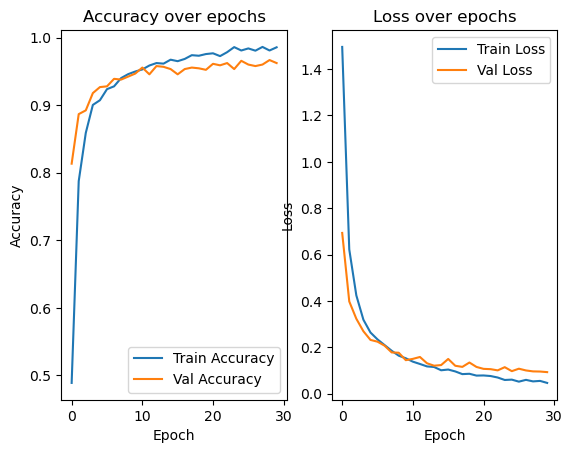

In [23]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [24]:
model.save("plant_model.keras")


In [25]:
import json

# Save class indices
with open('class_indices.json', 'w') as f:
    json.dump(train_gen.class_indices, f)
